In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Basic Configuration

From the following three examples chosse one and execute only the corresponding cells.

## Cosmology Example

In [ ]:
from astropy.io import ascii
import numpy as np
from collections import OrderedDict

name = "COS"

BLOCKLENGTH = 900. # block exposure time in s

# Define target lists.
fscience_targets = "pfs_target_list/pfs_preliminary_target_cosmology.dat"
fcal_stars       = "pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"


# fiducial field coortinate
RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used


# limit targets to a smaller field of view
#DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
DRMAX_SQ = np.inf

# In cosmology we don't dither, there is just one visit, one fiber configuration,
# and one exposure per field.
#
# Define dither pattern
DITHER_PATTERN = {"A" : ( 0.,0.)} # No Dithers, just one fiducial position

# more programmatic part of the configuration, load target lists
# and compute dither positions (on sky)

# Load target lists.
science_targets = ascii.read(fscience_targets)
cal_stars = ascii.read(fcal_stars)
sky_pos = ascii.read(fsky_pos)

# find field center and extent
cRA  = np.median( science_targets['RA'] )  
cDEC =  np.median( science_targets['DEC'] ) 
RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )

# set (or not) fiducial field center
if [RA0, DEC0] != [np.nan, np.nan]:
    cRA, cDEC = RA0, DEC0

pointings = OrderedDict()
for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
    pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
    pointings[did] = (pointing_RA, pointing_DEC) 


In [ ]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the cost 
# of non-observation and non-completion as 
# a two-tuple. The cost of non-completion 
# is typically larger as partial completion 
# of objects should be avoided.
cost_dict['sci_P01'] = (1e4,1e9)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = OrderedDict()
for i, pid in enumerate(pointings):
      cost_dict['visits'][pid] = i*10.

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf

# need one calibration star per exposure
supply_dict['cal_P01'] = 11 # force exactly 40
# need one sky positions per exposure
supply_dict['sky_P01'] = 200 # force exactly 240

## Galactic Areaology Example (UMi)

In [73]:
from astropy.io import ascii
import numpy as np
from collections import OrderedDict

name = "GA"

BLOCKLENGTH = 900. # block exposure time in s

# Define target lists.
fscience_targets = "pfs_target_list/pfs_preliminary_target_archaeology_umi.dat"
fcal_stars       = "pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars_mock.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_archaeology_umi_sky_mock.dat"

# Load target lists.
science_targets = ascii.read(fscience_targets)
cal_stars = ascii.read(fcal_stars)
sky_pos = ascii.read(fsky_pos)

# fiducial field coortinate
RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used

# limit targets to a smaller field of view
#DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
DRMAX_SQ = np.inf

  
# In the case of galaxy evolution we have multiple
# fields per target.
# They should be optimize simultanously.
# In each feild we will still dither around the fiducial field
# center coordinate.

# Define dither pattern
DITHER_PATTERN = OrderedDict()
# 12 - point round dither pattern ...
a = np.deg2rad( np.arange(0., 360., 30) )
r = 100. 
xx = np.sin(a) * r/3600.
yy = np.cos(a) * r/3600.
for i,(x,y) in enumerate(zip(xx,yy)):
    DITHER_PATTERN['{:02d}'.format(i) ] = ( x,y)

fields = OrderedDict()
fields['A'] = (228.200,   +67.500)
fields['B']  = (226.300,   +67.500)
fields['C'] = (226.000,   +66.900)
fields['D'] = (228.100,   +66.955)

# more programmatic part of the configuration, load target lists
# and comput dither positions (on sky)


pointings = OrderedDict()
for fid in fields:
    cRA,cDEC = fields[fid]
    for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
        pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
        pointings[ "P{}D{}".format(fid,did) ] = (pointing_RA, pointing_DEC) 

In [74]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the 
# cost of non-observation and non-completion 
# as a two-tuple. The cost of non-completion 
# is typically larger as partial completion 
# of objects should be avoided.
cost_dict['sci_P01'] = (1000000.,1e15)
cost_dict['sci_P02'] = (1000000.,1e15)
cost_dict['sci_P03'] = (1000000.,1e15)
cost_dict['sci_P04'] = (1000000.,1e15)
cost_dict['sci_P05'] = (1000000.,1e15)
cost_dict['sci_P06'] = (1000.,1e15)
cost_dict['sci_P07'] = (1000.,1e15)
cost_dict['sci_P08'] = (1000.,1e15)
cost_dict['sci_P09'] = (1000.,1e15)
cost_dict['sci_P10'] = (1000.,1e15)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = OrderedDict()
for i, pid in enumerate(pointings):
      cost_dict['visits'][pid] = i*10.

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf
supply_dict['sci_P02'] = inf
supply_dict['sci_P03'] = inf
supply_dict['sci_P04'] = inf
supply_dict['sci_P05'] = inf
supply_dict['sci_P06'] = inf
supply_dict['sci_P07'] = inf
supply_dict['sci_P08'] = inf
supply_dict['sci_P09'] = inf
supply_dict['sci_P10'] = inf

# needed calibration star per exposure
supply_dict['cal_P01'] = 40 # inf = try to get as many as  possible
# needed sky positions per exposure
supply_dict['sky_P01'] = 240 # inf = try to get as many as  possible


## Galaxy Evolution Example

In [34]:
from astropy.io import ascii
import numpy as np

name = "GE"

# Define target lists.
fscience_targets = "pfs_target_list/pfs_preliminary_target_galaxy.dat"
fcal_stars       = "pfs_target_list/pfs_preliminary_target_galaxy_fcstars_mock.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_galaxy_sky_mock.dat"


# fiducial field coortinate
RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used


# limit targets to a smaller field of view
#DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
DRMAX_SQ = np.inf

    
#Define dither pattern
DITHER_PATTERN = OrderedDict()
# manually ...

# dither in a hexagon ...
a = np.deg2rad( np.arange(0., 360., 60) )
r = 100. 
xx = np.sin(a) * r/3600.
yy = np.cos(a) * r/3600.
for i,(x,y) in enumerate(zip(xx,yy)):
    DITHER_PATTERN['D{:02d}'.format(i) ] = ( x,y)


BLOCKLENGTH = 900. # block exposure time in s


# more programmatic part of the configuration, load target lists
# and comput dither positions (on sky)

# Load target lists.
science_targets = ascii.read(fscience_targets)
cal_stars = ascii.read(fcal_stars)
sky_pos = ascii.read(fsky_pos)

# find field center and extent
cRA  = np.median( science_targets['RA'] )  
cDEC =  np.median( science_targets['DEC'] ) 
RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )

# set (or not) fiducial field center
if [RA0, DEC0] != [np.nan, np.nan]:
    cRA, cDEC = RA0, DEC0

pointings = OrderedDict()
for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
    pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
    pointings[did] = (pointing_RA, pointing_DEC) 

In [ ]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the cost 
# of non-observation and non-completion as 
# a two-tuple. The cost of non-completion 
# is typically larger as partial completion 
# of objects should be avoided.
cost_dict['sci_P01'] = (10000000000.,1e15)
cost_dict['sci_P02'] = (1000000000.,1e15)
cost_dict['sci_P03'] = (100000000.,1e15)
cost_dict['sci_P04'] = (10000000.,1e15)
cost_dict['sci_P05'] = (1000000.,1e15)
cost_dict['sci_P06'] = (100000.,1e15)
cost_dict['sci_P07'] = (10000.,1e15)
cost_dict['sci_P08'] = (1000.,1e15)
cost_dict['sci_P09'] = (100.,1e15)
cost_dict['sci_P10'] = (10.,1e15)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = OrderedDict()
for i, pid in enumerate(pointings):
      cost_dict['visits'][pid] = i*10.

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf
supply_dict['sci_P02'] = inf
supply_dict['sci_P03'] = inf
supply_dict['sci_P04'] = inf
supply_dict['sci_P05'] = inf
supply_dict['sci_P06'] = inf
supply_dict['sci_P07'] = inf
supply_dict['sci_P08'] = inf
supply_dict['sci_P09'] = inf
supply_dict['sci_P10'] = inf

# need one calibration star per exposure
supply_dict['cal_P01'] = 40 # force exactly 40
# need one sky positions per exposure
supply_dict['sky_P01'] = 240 # force exactly 240


## General Configuration items

In [75]:
# You can limit the problem here by constraining it to a subregion of the focal plane

# good very minimal example
#RMAX   = 10.
#CENTER = [-0.,0.]
#fieldsize   = "tinytiny"

# check for changing visibility
#RMAX   = 10.
#CENTER = [7.,-12.]
#fieldsize   = "tiny"

# intermediate example
#RMAX   = 150.
#CENTER = [0.,0.]
#fieldsize   = "intermediate"

# good small example!
#RMAX   = 25.
#CENTER = [-0.,0.]
#fieldsize   = "small"

# do them all!
RMAX   = 310.
CENTER = [-0.,0.]
fieldsize   ="all"

In [76]:
ENABLE_COLLISION_AVOIDANCE = True # enable endpoint collision avoidance, slow if there is many (>> 10k) targets
PLOT_TARGET_DISTRIBUTION   = True
PLOT_SURVEY_PLAN           = False # plot network of survey plan. Only use when restricting to very small subegions of the focal plane!
PLOT_FOCAL_PLANE           = False # plot focal plane and indicate which cobras observe what targets. 
                                   # Only use when restricting to very small subegions of the focal plane!
    
RANDOM_PRIORITIES          = False # Randomly assign priority classes to sciencetargets 

# Some necessary preparation

In [77]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")


from matplotlib import pyplot as plt
%matplotlib inline

def pp(s):
    print(s)
    return s + "\n"

# Next two lines force automatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

# Datamodel for the flow network
import pfs_netflow.datamodel as dm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the catalogs, compute visibility ... 

In [78]:
# Convert data to lists for ETS.
import numpy as np
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique, array
from collections import OrderedDict


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{:02d}'.format(t, p)


dra = (ra - cRA)*cos(deg2rad(cDEC))
ddec = dec - cDEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

print( "{} science targets, {} calibration targets, and {} sky positions survive radial cut.".format(sum(ii_sci),sum(ii_cal),sum(ii_sky)))

10895 science targets, 400 calibration targets, and 10000 sky positions survive radial cut.


In [79]:
print ("Priority classes: ", np.unique(priorities))
# assign random priorities between 1 and 3 for the  science targets
if RANDOM_PRIORITIES:
    # Kohei's catalog already does come with priorities
    from numpy import random
    from numpy import array

    random.seed(42)

    N =  sum(ii_sci) 

    newpri = array( random.uniform(1.,4., size=N) , dtype=int)
    priorities = np.array(priorities)

    priorities[ii_sci] = newpri
    priorities = priorities.tolist()

Priority classes:  [ 1  2  3  4  5  6  7  8  9 10]


In [80]:
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = max( int(nrv), 1)
    
print( "Unique sequence of required revisits", unique( [v for v in nreqv_dict.values()] ))

Unique sequence of required revisits [ 1  2  4  8 12]


In [81]:
# RANDOMISE NUMBER OF REQUIRED VISISTS
RANDOMIZENREQ = False

if RANDOMIZENREQ:
    from numpy import random
    
    NVISITS = 10
    nv = np.floor( random.uniform(NVISITS+1, size=len(ID)) ) 

    # compute number of required visists from exposure times
    # and block length
    nreqv_dict = {}
    for id,t,nrv in zip(ID, types, nv):
        nreqv_dict[id] = int(nrv)

    print( "Required revisits", unique( [v for v in nreqv_dict.values()] ))

In [82]:
import pyETS
import pycconv

# Temporary, very crude method to convert Ra/Dec pairs to x/y coordinates
# on the focal plane. To be replaced by the official functionality once
# available.
# All input angles are expected in degrees.
def radec2pos(ras, decs, raTel=None, decTel=None, posang=0.,
              time="2016-04-03T08:00:00Z"):
    if raTel is None:
        raTel = np.average(ras)
    if decTel is None:
        decTel = np.average(decs)
    return pycconv.cconv(ras,decs,raTel,decTel,posang+90.,time)

# get a data structure containing the idealized cobras
ets_cobras = pyETS.getAllCobras()

# for every pointing, compute target positions
# in the focal plane 
# and a visibilty map
visibility_maps = OrderedDict()
ets_target_pos  = OrderedDict()
for pid,(pointing_RA,pointing_DEC) in pointings.items():
    # Parse a target file and return the quantities of interest
    ets_target_pos[pid] = radec2pos(ra, dec, raTel=pointing_RA, decTel=pointing_DEC)

    # get a list of targets, and a list of Cobras that can observe them
    # keys contain object index
    # values contain indices of cobras that can observe that object.
    visibility_maps[pid] = pyETS.getVis(ets_target_pos[pid], ets_cobras)

In [83]:
#Interface to the new ETS, convert cobras, visibilities and targets to old style format
from collections import OrderedDict

# obtain cobra centers in old ETS dictionary style
cobras = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][0] ), np.imag( ets_cobras[i][0] )
        cobras["{:d}".format(i)] = [x,y]
        
# obtain dot centers in dictionary style
dots = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][-2] ), np.imag( ets_cobras[i][-2] )
        r = ets_cobras[i][-1]
        dots["{:d}".format(i)] = [x,y,r]


# obtain target positions in old ETS dictionary style
target_fplane_pos = OrderedDict()
for pid in ets_target_pos:
    tt = OrderedDict()
    for j,c in enumerate(ets_target_pos[pid]):
            x,y = np.real(c),np.imag(c)
            tt[ID[j]] = [float(x),float(y)]
    target_fplane_pos[pid] = tt

# obtain visibilities in old ETS dictionary style
visibilities = OrderedDict()
for pid in visibility_maps:
    vv = OrderedDict()   
    for v in visibility_maps[pid]:
        t = ID[v]
        cc = ["{:d}".format(c) for c in visibility_maps[pid][v]]
        vv[t] = cc
    visibilities[pid] = vv    

In [84]:
# This plot the focal plane, with all the target positions at all
# dither positions. Can take very long, shoudl only be done with a subset of the total 
# targets.

def filterFoV(xx,yy, maxx=20., maxy=20.):
    ii  = xx >= -maxx
    ii *= xx <=  maxx
    ii *= yy >= -maxy
    ii *= yy <=  maxy
    return ii

def my_circle_scatter(axes, x_array, y_array, radius, **kwargs):
    for x, y, r in zip(x_array, y_array, radius):
        circle = plt.Circle((x,y), radius=r, edgecolor='k', facecolor='grey', **kwargs)
        axes.add_patch(circle)
    return True

def plotFP(cobras,dots,targets,maxx=20.,maxy=20.):
    
    f = plt.figure(figsize=[10,10])
    ax = plt.subplot(1,1,1)
    
    # rearrange dot and cobra information for easy plotting
    dxx = np.array( [d[0] for did, d in dots.items()] )
    dyy = np.array( [d[1] for did, d in dots.items()] )
    drr = np.array( [d[2] for did, d in dots.items()] )
    ciddd = np.array( [did for did, d in dots.items()] )

    cxx = np.array( [c[0] for cid, c in cobras.items()] )
    cyy = np.array( [c[1] for cid, c in cobras.items()] )
    ciddd = np.array( [cid for cid, t in cobras.items()] )
    
    # plot cobras
    ii = filterFoV(cxx,cyy,maxx=maxx,maxy=maxy)
    plt.plot(cxx[ii],cyy[ii],'.', c='orange')
    ii = filterFoV(cxx,cyy )
    for x,y,l in zip(cxx[ii],cyy[ii],ciddd[ii]):
        plt.text(x,y,l)

    # plot dots
    ii = filterFoV(dxx,dyy,maxx=maxx,maxy=maxy)
    my_circle_scatter(ax, dxx[ii],dyy[ii], drr[ii] )
    

    N = len(target_fplane_pos)
    for i,pid in enumerate(target_fplane_pos):
        alpha = 1. - float(i)/float( N )

        # rearrange target information for easy plotting
        txx = np.array( [t[0] for tid, t in target_fplane_pos[pid].items()] )
        tyy = np.array( [t[1] for tid, t in target_fplane_pos[pid].items()] )
        tiddd = np.array( [tid for tid, t in target_fplane_pos[pid].items()] )

        # plot targets
        ii = filterFoV(txx,tyy,maxx=maxx,maxy=maxy)
        plt.plot(txx[ii],tyy[ii],'bo', alpha=alpha, label='pointing {}'.format(pid))

        for x,y,l in zip(txx[ii],tyy[ii],tiddd[ii]):
            plt.text(x,y,l, size=8)

        # plot visibility arcs
        if True:
            for tid,cc in visibilities[pid].items():
                tx,ty = target_fplane_pos[pid][tid]
                for c in cc:
                    cx,cy = cobras[c]
                    #print c
                    #plt.text(cx,cy,"{}".format(c) )
                    plt.plot([cx,tx],[cy,ty],'k-', alpha=alpha)


        
            
       #plt.text(zip(txx[ii],tyy[ii]),tiddd[ii], size=6)   

    plt.axis('equal')
    plt.xlim([-maxx,maxx])
    plt.ylim([-maxy,maxy])
    plt.legend()
    
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    
#plotFP(cobras,dots,target_fplane_pos,maxx=20.,maxy=20.)

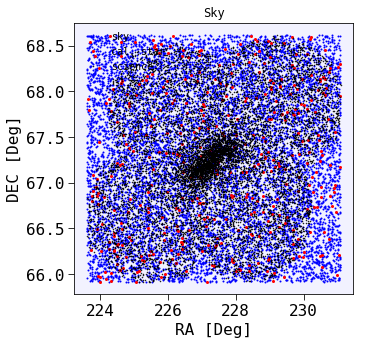

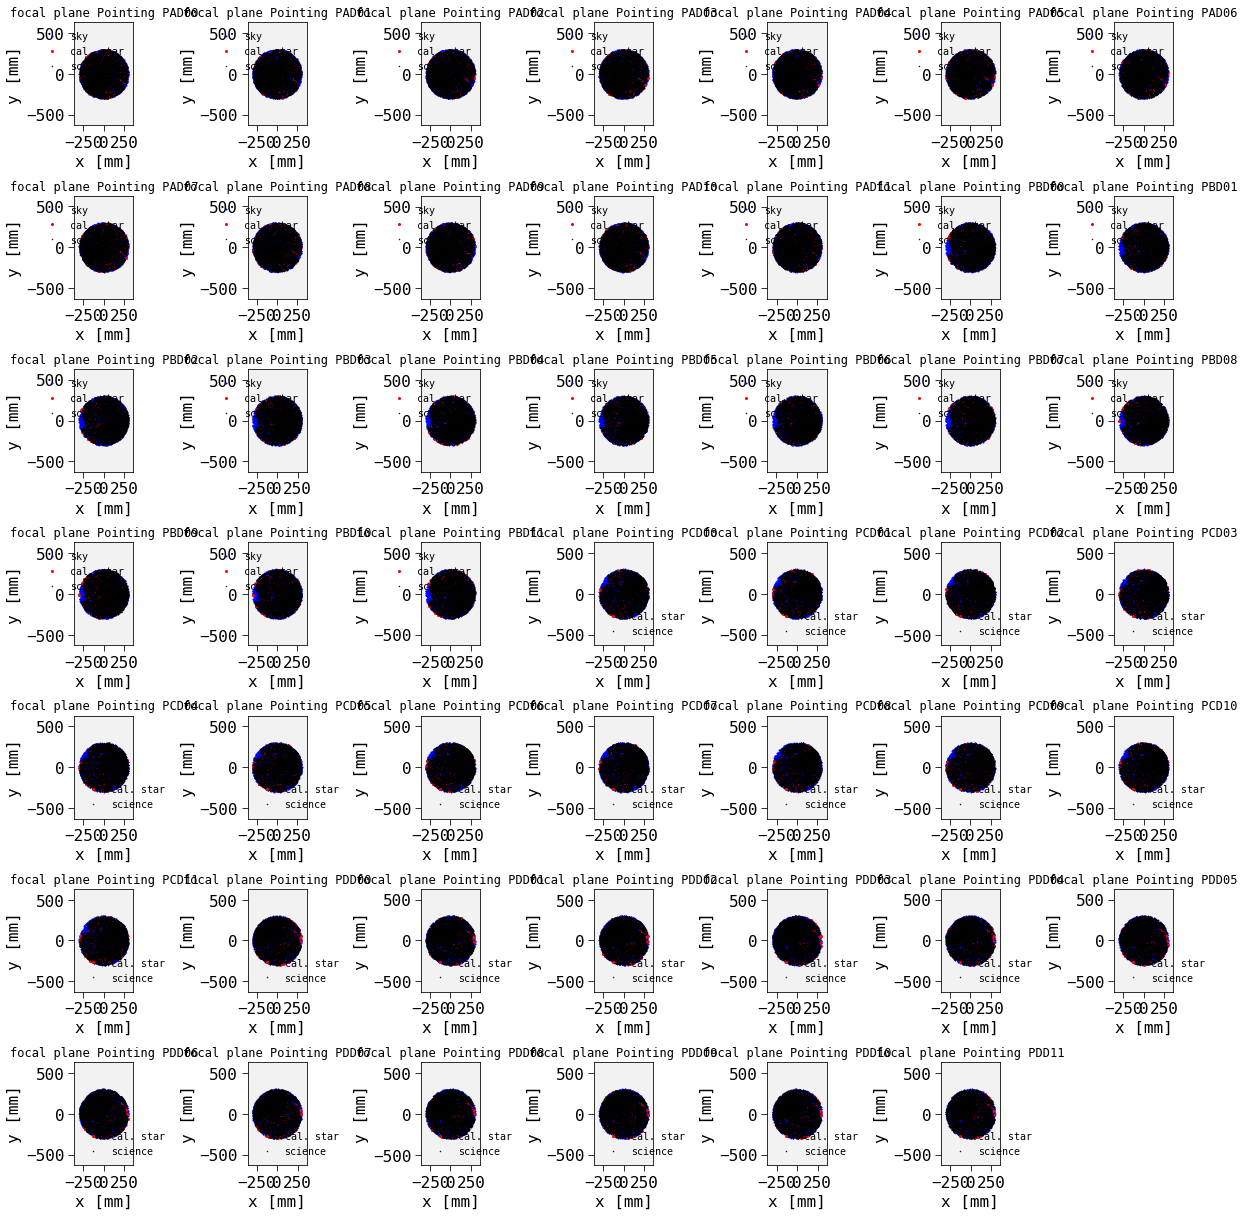

In [88]:
if PLOT_TARGET_DISTRIBUTION:
    from pfs_netflow.plotting import plotTargetDistribution
    plotTargetDistribution(ra, dec, types, pointings, target_fplane_pos, class_dict)

# Collisions

In [89]:
from scipy.spatial.distance import cdist

PLOT = False

# find collision pairs
fiber_collision_radius = 1.
        
# I am sure this code cound be massively optimized by subdeviding the focal plane
# also we probably don't need to do this on a per-pointing basis.
collision_pairs = OrderedDict()

if ENABLE_COLLISION_AVOIDANCE:
    for pid,(pointing_RA,pointing_DEC) in pointings.items():

        targets = target_fplane_pos[pid]
        tclasses = [class_dict[tid] for tid in target_fplane_pos[pid]]

        txx = np.array( [t[0] for tid, t in targets.items()] )
        tyy = np.array( [t[1] for tid, t in targets.items()] )

        _ii_sci = list( map( lambda x : x.startswith('sci') , tclasses ) )
        _ii_sky = list( map( lambda x : x.startswith('sky') , tclasses ) ) 
        _ii_cal = list( map( lambda x : x.startswith('cal') , tclasses ) )

        if PLOT:
            f = plt.figure(figsize=[5,5])
            plt.subplot()
            plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')
            plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
            plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


        N = len(ID)
        points = list( zip(txx,tyy) )
        Y = cdist( points[:N], points[:N] )

        # any target separation that is smaller than 2 x the collision radius will be flagged a s collision
        cc = Y <= (fiber_collision_radius*2.) 
        ncoll = int( (np.sum(cc.flatten()) - N)/2. )

        print ("Pointing {}: Found  {:d} collision pairs.".format( pid, ncoll  ))

        # identify collision pairs
        collision_pairs[pid] = []
        # array of indices
        ii = np.arange(N)
        for i in range(cc.shape[0]):
            x1,y1 =  txx[i], tyy[i]
            # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
            jj = ii[ cc[i,:] * ii > i ] 
            for j in jj: 
                if cc[i,j]:
                    x2,y2 =  txx[j], tyy[j]
                    collision_pairs[pid].append([(ID[i],x1,y1),(ID[j],x2,y2)])


        if PLOT:
            for cp in collision_pairs[pid]:
                plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')


            plt.axis('equal')
            l = plt.legend()
            l.draw_frame(False)
            plt.xlabel("x [mm]")
            plt.ylabel("y [mm]")
            plt.xlim([-15,15])

Pointing PAD00: Found  4087 collision pairs.
Pointing PAD01: Found  4090 collision pairs.
Pointing PAD02: Found  4091 collision pairs.
Pointing PAD03: Found  4101 collision pairs.
Pointing PAD04: Found  4107 collision pairs.
Pointing PAD05: Found  4120 collision pairs.
Pointing PAD06: Found  4121 collision pairs.
Pointing PAD07: Found  4127 collision pairs.
Pointing PAD08: Found  4122 collision pairs.
Pointing PAD09: Found  4118 collision pairs.
Pointing PAD10: Found  4106 collision pairs.
Pointing PAD11: Found  4091 collision pairs.
Pointing PBD00: Found  4029 collision pairs.
Pointing PBD01: Found  4036 collision pairs.
Pointing PBD02: Found  4039 collision pairs.
Pointing PBD03: Found  4048 collision pairs.
Pointing PBD04: Found  4054 collision pairs.
Pointing PBD05: Found  4054 collision pairs.
Pointing PBD06: Found  4053 collision pairs.
Pointing PBD07: Found  4047 collision pairs.
Pointing PBD08: Found  4041 collision pairs.
Pointing PBD09: Found  4031 collision pairs.
Pointing P

# Invert visibilities

In [90]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.
def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = OrderedDict()
    for pid in visibilities:
        cnt = 0
        ivisibilities[pid] = OrderedDict()
        for v in visibilities[pid]:
            t = v
            cc = visibilities[pid][v]

            for c in cc:
                if c in ivisibilities[pid]:
                    ivisibilities[pid][c].append(v)
                else:
                    ivisibilities[pid][c] = [v]

    return ivisibilities

ivisibilities = invert_vis(visibilities)           

In [91]:
for pid in visibilities:
    print("Pointing {}".format(pid))
    nsci_observable = 0
    ncal_observable = 0
    nsky_observable = 0

    for tid,v in visibilities[pid].items():
        if len(v) > 0:
            if class_dict[tid][:3] == 'cal':
                ncal_observable += 1
            elif class_dict[tid][:3] == 'sky':
                nsky_observable += 1
            elif class_dict[tid][:3] == 'sci':
                nsci_observable += 1
            #break


    print("{} targets positions in total.".format(sum(ii_sci) ))
    print("{} cal. targets in total.".format(sum(ii_cal) ))
    print("{} sky positions in total.".format(sum(ii_sky) ))
    print("{} cobras have at least one target in reach.".format(len(ivisibilities[pid])))
    print("{} science targets\n{} calibration targets, \
    and \n{} sky positions are in reach of at least one cobra.".format(nsci_observable, ncal_observable, nsky_observable))  
    print("")

Pointing PAD00
10895 targets positions in total.
400 cal. targets in total.
10000 sky positions in total.
2055 cobras have at least one target in reach.
3309 science targets
62 calibration targets,     and 
1486 sky positions are in reach of at least one cobra.

Pointing PAD01
10895 targets positions in total.
400 cal. targets in total.
10000 sky positions in total.
2065 cobras have at least one target in reach.
3321 science targets
61 calibration targets,     and 
1490 sky positions are in reach of at least one cobra.

Pointing PAD02
10895 targets positions in total.
400 cal. targets in total.
10000 sky positions in total.
2044 cobras have at least one target in reach.
3310 science targets
56 calibration targets,     and 
1492 sky positions are in reach of at least one cobra.

Pointing PAD03
10895 targets positions in total.
400 cal. targets in total.
10000 sky positions in total.
2046 cobras have at least one target in reach.
3383 science targets
64 calibration targets,     and 
1471

10895 targets positions in total.
400 cal. targets in total.
10000 sky positions in total.
2018 cobras have at least one target in reach.
2701 science targets
54 calibration targets,     and 
1417 sky positions are in reach of at least one cobra.

Pointing PCD09
10895 targets positions in total.
400 cal. targets in total.
10000 sky positions in total.
2012 cobras have at least one target in reach.
2720 science targets
53 calibration targets,     and 
1436 sky positions are in reach of at least one cobra.

Pointing PCD10
10895 targets positions in total.
400 cal. targets in total.
10000 sky positions in total.
1989 cobras have at least one target in reach.
2748 science targets
49 calibration targets,     and 
1431 sky positions are in reach of at least one cobra.

Pointing PCD11
10895 targets positions in total.
400 cal. targets in total.
10000 sky positions in total.
2005 cobras have at least one target in reach.
2792 science targets
57 calibration targets,     and 
1441 sky positions 

# Execute netflow

In [92]:
# Build the survey plan graph.

from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan

print("Creating graph ...")

# for per-ponting list of targets, build
# single list of targets with multiple entries for the focal plane positions
targets = OrderedDict()
for pid in target_fplane_pos:
    tt = target_fplane_pos[pid] 
    for tid in tt:
        x,y = tt[tid]
        if not tid in targets:
             targets[tid] = OrderedDict()
        targets[tid][pid] = (x,y)
        

# build the survey plan graph
g = buildSurveyPlan(cobras, targets, nreqv_dict, visibilities, class_dict,\
                    cost_dict, supply_dict, RMAX, CENTER=(0.,0.), COBRAS=[])

print("Done.")

for pid in pointings:
    print("Pointing {}".format(pid))
    for c in g.sciTargetClasses:

        nsci = 0
        nsci_reachable = 0
        for t in g.sciTargetClasses[c].targets.values():
            if t.outarcs != []:
                nsci += 1
                nsci_reachable += 1

        print("   Number of targets in {} is {}.".format(c, nsci ) )
        print("   Number of observable targets in {} is {}.".format(c, nsci_reachable ) )


    ncal = 0
    ncal_reachable = 0
    for t in g.calTargetClasses['TClass_cal_P01_v{}'.format(pid)].targets.values():
        if t.outarcs != []:
            ncal += 1
            ncal_reachable += 1
    print("   Number of calibration stars: {}".format(ncal) )
    print("   Number of observable calibration stars: {}".format( ncal_reachable )) 


    nsky = 0
    nsky_reachable = 0
    for t in g.calTargetClasses['TClass_sky_P01_v{}'.format(pid)].targets.values():
        if t. outarcs != []:
            nsky += 1
            nsky_reachable += 1
    print("   Number of sky positions: {}".format(nsky) )
    print("   Number of observable sky positions: {}".format(nsky_reachable) )



Creating graph ...
buildSurveyPlan
Done.
Pointing PAD00
   Number of targets in TClass_sci_P01 is 57.
   Number of observable targets in TClass_sci_P01 is 57.
   Number of targets in TClass_sci_P02 is 202.
   Number of observable targets in TClass_sci_P02 is 202.
   Number of targets in TClass_sci_P03 is 961.
   Number of observable targets in TClass_sci_P03 is 961.
   Number of targets in TClass_sci_P04 is 764.
   Number of observable targets in TClass_sci_P04 is 764.
   Number of targets in TClass_sci_P05 is 926.
   Number of observable targets in TClass_sci_P05 is 926.
   Number of targets in TClass_sci_P06 is 987.
   Number of observable targets in TClass_sci_P06 is 987.
   Number of targets in TClass_sci_P07 is 1128.
   Number of observable targets in TClass_sci_P07 is 1128.
   Number of targets in TClass_sci_P08 is 1347.
   Number of observable targets in TClass_sci_P08 is 1347.
   Number of targets in TClass_sci_P09 is 1391.
   Number of observable targets in TClass_sci_P09 is 1

   Number of calibration stars: 66
   Number of observable calibration stars: 66
   Number of sky positions: 1474
   Number of observable sky positions: 1474
Pointing PAD09
   Number of targets in TClass_sci_P01 is 57.
   Number of observable targets in TClass_sci_P01 is 57.
   Number of targets in TClass_sci_P02 is 202.
   Number of observable targets in TClass_sci_P02 is 202.
   Number of targets in TClass_sci_P03 is 961.
   Number of observable targets in TClass_sci_P03 is 961.
   Number of targets in TClass_sci_P04 is 764.
   Number of observable targets in TClass_sci_P04 is 764.
   Number of targets in TClass_sci_P05 is 926.
   Number of observable targets in TClass_sci_P05 is 926.
   Number of targets in TClass_sci_P06 is 987.
   Number of observable targets in TClass_sci_P06 is 987.
   Number of targets in TClass_sci_P07 is 1128.
   Number of observable targets in TClass_sci_P07 is 1128.
   Number of targets in TClass_sci_P08 is 1347.
   Number of observable targets in TClass_sc

Pointing PBD07
   Number of targets in TClass_sci_P01 is 57.
   Number of observable targets in TClass_sci_P01 is 57.
   Number of targets in TClass_sci_P02 is 202.
   Number of observable targets in TClass_sci_P02 is 202.
   Number of targets in TClass_sci_P03 is 961.
   Number of observable targets in TClass_sci_P03 is 961.
   Number of targets in TClass_sci_P04 is 764.
   Number of observable targets in TClass_sci_P04 is 764.
   Number of targets in TClass_sci_P05 is 926.
   Number of observable targets in TClass_sci_P05 is 926.
   Number of targets in TClass_sci_P06 is 987.
   Number of observable targets in TClass_sci_P06 is 987.
   Number of targets in TClass_sci_P07 is 1128.
   Number of observable targets in TClass_sci_P07 is 1128.
   Number of targets in TClass_sci_P08 is 1347.
   Number of observable targets in TClass_sci_P08 is 1347.
   Number of targets in TClass_sci_P09 is 1391.
   Number of observable targets in TClass_sci_P09 is 1391.
   Number of targets in TClass_sci_P

   Number of observable targets in TClass_sci_P09 is 1391.
   Number of targets in TClass_sci_P10 is 2205.
   Number of observable targets in TClass_sci_P10 is 2205.
   Number of calibration stars: 51
   Number of observable calibration stars: 51
   Number of sky positions: 1433
   Number of observable sky positions: 1433
Pointing PCD06
   Number of targets in TClass_sci_P01 is 57.
   Number of observable targets in TClass_sci_P01 is 57.
   Number of targets in TClass_sci_P02 is 202.
   Number of observable targets in TClass_sci_P02 is 202.
   Number of targets in TClass_sci_P03 is 961.
   Number of observable targets in TClass_sci_P03 is 961.
   Number of targets in TClass_sci_P04 is 764.
   Number of observable targets in TClass_sci_P04 is 764.
   Number of targets in TClass_sci_P05 is 926.
   Number of observable targets in TClass_sci_P05 is 926.
   Number of targets in TClass_sci_P06 is 987.
   Number of observable targets in TClass_sci_P06 is 987.
   Number of targets in TClass_sc

In [93]:
# now build the LP problem
from pfs_netflow.lp import buildLPProblem, solve
from pulp import LpStatus, value
import time


def setflows(g,flows):
    for a in g.arcs.values():
        k = '{}={}'.format(a.startnode.id,a.endnode.id)
        if k in flows:
            a.flow = value(flows[k])


    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)
NVISITS = len( g.visits )

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(int(NCalTargets/NVISITS) ))
summary += pp(" {} cobras".format(NCobras))
summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

summary += pp("Building LP problem ...")
start_time = time.time()
prob, flows, cost = buildLPProblem(g, cat='Integer')
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

__ = prob.writeMPS("mps/{}_{}_{}_{}.mps".format(name, fieldsize, RMAX, NVISITS), rename=1)

NVISITS = 48
Searching optimal strategy to observe in 
 48 visits
 9968 science targets
 7623 calib. targets
 2394 cobras
num nodes: 971749
num edges: 1272609
Building LP problem ...
Building cost equation ...
 Time to completion: 65.63 s
Time to build model: 7.2697e+01 s


In [94]:
import pulp
from pfs_netflow.survey_plan import compute_collision_flow_pairs
  
if ENABLE_COLLISION_AVOIDANCE:
    flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
    print("Adding {} collision avoidance constraints.".format(len(flow_pairs)))              
    for fp in flow_pairs:
        prob += pulp.lpSum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1.

__ = prob.writeMPS("mps/{}_{}_{}_{}.mps".format(name, fieldsize, RMAX, NVISITS, rename=1), rename=1)

Adding 8808672 collision avoidance constraints.


In [95]:
from numpy import random

# solve it!

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()

#maxSeconds=2400.
#status = solve(prob, maxSeconds=maxSeconds)
status = solve(prob, solver="GUROBI")


time_to_solve = time.time() - start_time
summary += pp("Solve status is [{}].".format( LpStatus[status] ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))


Solving LP problem ...
Optimize a model with 9778027 rows, 1272610 columns and 20516147 nonzeros
Variable types: 1 continuous, 1272609 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+15]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [1e+00, 2e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 5393062 rows and 764663 columns (presolve time = 7s) ...
Presolve removed 9496203 rows and 954579 columns (presolve time = 15s) ...
Presolve removed 9703737 rows and 1074417 columns (presolve time = 20s) ...
Presolve removed 9711794 rows and 1098465 columns (presolve time = 47s) ...
Presolve removed 9723943 rows and 1130562 columns (presolve time = 55s) ...
Presolve removed 9723943 rows and 1130562 columns
Presolve time: 55.31s
Presolved: 54084 rows, 142048 columns, 337612 nonzeros
Variable types: 0 continuous, 142048 integer (139224 binary)
Found heurist

In [97]:
from pfs_netflow.survey_plan import computeStats

stats = computeStats(g, flows, cost)

summary += pp("{} = {}".format('Value of cost function',value(stats['cost']) ) )
summary += pp("[{}] out of {} science targets get observed.".format(int(stats['NSciObs']) ,NSciTargets) )
summary += pp("For {} out of these all required exposures got allocated.".format(stats['NSciComplete']))  
summary += pp("Per target class completion:")
                                                            
summary += pp("   {:15s} {:10s} {:10s} {:10s}".format('class', 'total', 'observed', 'completed') )
for tc,compl in stats['completion'].items():
    summary += pp("   {:15s} {:10d} {:10d} {:10d}".format(tc, compl['total'],compl['observed'],compl['completed']))                                                                       
    #print(tc, compl)                                                                  
summary += pp("{} targets get sent down the overflow arc.".format(stats['Noverflow']))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats['Ncobras_used'], NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats['Ncobras_fully_used']))

setflows(g,flows)

Value of cost function = 499320730.0
[4963] out of 9968 science targets get observed.
For 4910 out of these all required exposures got allocated.
Per target class completion:
   class           total      observed   completed 
   TClass_sci_P01          57         33         33
   TClass_sci_P02         202        181        181
   TClass_sci_P03         961        887        878
   TClass_sci_P04         764        662        660
   TClass_sci_P05         926        655        654
   TClass_sci_P06         987        542        542
   TClass_sci_P07        1128        718        718
   TClass_sci_P08        1347        880        878
   TClass_sci_P09        1391        260        255
   TClass_sci_P10        2205        145        111
5005 targets get sent down the overflow arc.
2394 out of 2394 cobras observed a target in one or more exposures.
0 cobras observed a target in all exposures.


In [98]:
# test if really no colliding targets were observed
# This needs to be added to the survey plan and buildLPProblem methods.
#
import pulp
from pulp import value

flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
 
NCOLL = 0
for fp in flow_pairs:
    
    if value( flows[ fp[0] ] ) > 0. and value( flows[ fp[1] ] ) > 0.:
        #print("{} {} in collision".format(fp[0],fp[1]))
        NCOLL += 1
                             
print("Detected {} endpoint collisions".format(NCOLL))

Detected 0 endpoint collisions


In [99]:
if PLOT_SURVEY_PLAN:
    plotSurveyPlan(g)

In [100]:
if PLOT_FOCAL_PLANE:
    from pfs_netflow.plotting import plotFocalPlane
    for pid in pointings:
        plotFocalPlane(g, pid=pid, W=30, XC=0., YC=0., name="", figsize=[5,5])


Computing target completion ...
Pointing PAD00
Pointing PAD01
Pointing PAD02
Pointing PAD03
Pointing PAD04
Pointing PAD05
Pointing PAD06
Pointing PAD07
Pointing PAD08
Pointing PAD09
Pointing PAD10
Pointing PAD11
Pointing PBD00
Pointing PBD01
Pointing PBD02
Pointing PBD03
Pointing PBD04
Pointing PBD05
Pointing PBD06
Pointing PBD07
Pointing PBD08
Pointing PBD09
Pointing PBD10
Pointing PBD11
Pointing PCD00
Pointing PCD01
Pointing PCD02
Pointing PCD03
Pointing PCD04
Pointing PCD05
Pointing PCD06
Pointing PCD07
Pointing PCD08
Pointing PCD09
Pointing PCD10
Pointing PCD11
Pointing PDD00
Pointing PDD01
Pointing PDD02
Pointing PDD03
Pointing PDD04
Pointing PDD05
Pointing PDD06
Pointing PDD07
Pointing PDD08
Pointing PDD09
Pointing PDD10
Pointing PDD11
Done, write stats.txt.
  V   nsci ncal nsky nsci_obs ncal_obs nsky_obs nsci_cum
----- ---- ---- ---- -------- -------- -------- --------
PAD00 1436   40  240     3309       62     1486     1436
PAD01 1274   40  240     3321       61     1490     27

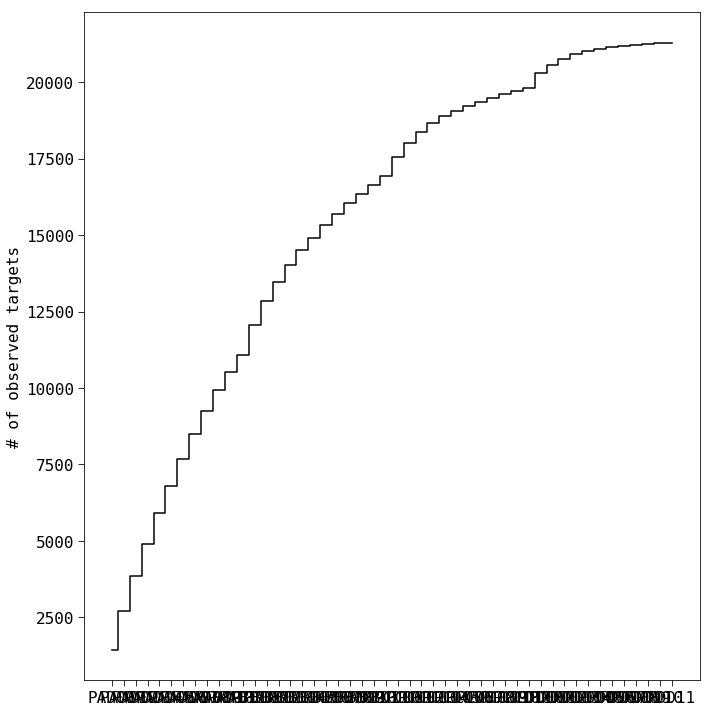

In [ ]:
# Performace evaluation: Observed targets vs. number of visits

from astropy.io import ascii
from pfs_netflow import survey_plan as sp

sp.computeTargetCompletion(g, visibilities, class_dict, "stats.txt")

t = ascii.read("stats.txt")
print(t)

f = plt.figure(figsize = [10,10])
plt.plot(t['nsci_cum'], drawstyle='steps-mid')
plt.xticks(np.arange(len(t)),t['V'])
plt.ylabel("# of observed targets")

f.tight_layout()
##

nsci = sum( [class_dict[t][:3] == "sci" for t in targets] )
ncal = sum( [class_dict[t][:3] == "cal" for t in targets] )
nsky = sum( [class_dict[t][:3] == "sky" for t in targets] )

sum( [class_dict[t][:3] == "cal" for t in targets] )


print("{} targets positions in total.".format( nsci ))
print("{} cal. targets in total.".format( ncal ))
print("{} sky positions in total.".format( nsky ))

In [ ]:
# Statistics on cobra motion

# array of all distances for all possible target/cobra pairs
dd =  np.array( [ a.d for a in g.targetVisitToCobraVisitArcs.values()] )
# array of flows for all possible target/cobra pairs
ff =  np.array( [ value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.values()] )

# caclulate mean cobra move distance
ii = ff > 0.
mn_movedist = np.mean( dd[ii] )
min_movedist = np.min( dd[ii] )
max_movedist = np.max( dd[ii] )
std_movedist = np.std( dd[ii] )

print("mn_movedist =  {:.3f}mm".format(mn_movedist) )
print("min_movedist = {:.3f}mm".format(min_movedist) )
print("max_movedist = {:.3f}mm".format(max_movedist) )
print("std_movedist = {:.3f}mm".format(std_movedist) )

cm = np.sum([ a.cost * value(flows[a.id]) for a in g.targetVisitToCobraVisitArcs.values() ])

print("cost from moves = {}".format(cm) )


plt.hist( dd[ii] )
plt.xlabel("d[mm]")
plt.ylabel("N")

mn_movedist =  3.091mm
min_movedist = 0.006mm
max_movedist = 4.750mm
std_movedist = 1.149mm


In [ ]:
1/0

# Routine to generate random target lists

In [ ]:

# make up calibration stars and sky positions
# careful IDs of all objects must be unique!!!
from astropy.table import Table, Column

cal_stars = Table()
sky_pos   = Table()

NSTAR = 400
NSKY  = 10000

rr_star = np.random.uniform(size=NSTAR, low=RAmin, high=RAmax)
dd_star = np.random.uniform(size=NSTAR, low=DECmin, high=DECmax)
tt_star = np.ones_like(rr_star) * 900.
pp_star = np.ones_like(rr_star) * 1

cal_stars['ID']        = Column(["F{:06d}".format(i) for i in range(NSTAR)], unit='', description='')
cal_stars['RA']        = Column(rr_star, unit='deg', description='RA')
cal_stars['DEC']       = Column(dd_star, unit='deg', description='DEC')
cal_stars['EXP_TIME']  = Column(tt_star, unit='s', description='Exposure time')
cal_stars['Priority']  = Column(pp_star, unit='', description='Priority', dtype='int')


rr_sky = np.random.uniform(size=NSKY, low=RAmin, high=RAmax)
dd_sky = np.random.uniform(size=NSKY, low=DECmin, high=DECmax)
tt_sky = np.ones_like(rr_sky) * 900.
pp_sky = np.ones_like(rr_sky) * 1

sky_pos['ID']        = Column(["K{:06d}".format(i) for i in range(NSKY)], unit='', description='')
sky_pos['RA']        = Column(rr_sky, unit='deg', description='RA')
sky_pos['DEC']       = Column(dd_sky, unit='deg', description='DEC')
sky_pos['EXP_TIME']  = Column(tt_sky, unit='s', description='Exposure time')
sky_pos['Priority']  = Column(pp_sky, unit='', description='Priority', dtype='int')

cal_stars.write("pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars.dat", format="ascii", overwrite=True)
sky_pos.write("pfs_target_list/pfs_preliminary_target_archaeology_umi_sky.dat", format="ascii", overwrite=True)

# prepare Cobra/Target pairs to run trajectory collision detection

In [ ]:
list(pointings.keys())[0]

In [ ]:
pid = list(pointings.keys())[0]
 
# initialize assigment list with Null
# as required by the collision simulator code.
assignments = OrderedDict()
for c in g.cobras.values():
    assignments[c.id] = 'Null'

# Now find which cobras have been assigned to which targets. 
# Loop over all targetVisit to CobraVisit arcs.Filter for those that correspond to the current visit.
for a in filter(lambda x : x.visit == visit, g.targetVisitToCobraVisitArcs.values()):
    
    if a.flow > 0.:
        t = a.startnode.target
        c = a.endnode.cobra 
        assignments[c.id] = t.id
        
for cid,tid in assignments.items():
    print("{:6s} observes {:10s}".format(cid, tid))


In [ ]:
# feed to collision code
import numpy as np
import time as time

import sys
sys.path.append("/Users/mxhf/work/MPE/pfs/src/ics_cobraOps/python")

import ics.cobraOps.plotUtils as plotUtils
import ics.cobraOps.targetUtils as targetUtils

from ics.cobraOps.Bench import Bench
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector
from ics.cobraOps.RandomTargetSelector import RandomTargetSelector

# Create the bench instanceroduct)
#bench = Bench(layout="full", calibrationProduct=calibrationP
cpos = [ [ complex(g.cobras[cid].getX(pid) , g.cobras[cid].getY(pid)) ] for cid in assignments]
bench = Bench(cobraCenters=np.array( cpos ))

print("Number of cobras:", bench.cobras.nCobras)

In [ ]:
# Calculate the total number of targets based on the bench properties
medianPatrolAreaRadius = np.median(bench.cobras.rMax)


nTargets = int(np.ceil(density * (bench.radius / medianPatrolAreaRadius) ** 2))

# Calculate the uniformly distributed target positions
ang = 2 * np.pi * np.random.random(nTargets)
radius = bench.radius * np.sqrt(np.random.random(nTargets))
targetPositions = bench.center + radius * np.exp(1j * ang)

return TargetGroup(targetPositions)

In [ ]:
# Generate the targets
targets = targetUtils.generateRandomTargets(targetDensity, bench)
print("Number of simulated targets:", targets.nTargets)

# Select the targets
selector = DistanceTargetSelector(bench, targets)
selector.run()
selectedTargets = selector.getSelectedTargets()

# Simulate an observation
start = time.time()
simulator = CollisionSimulator(bench, selectedTargets)
simulator.run()
print("Number of cobras involved in collisions:", simulator.nCollisions)
print("Number of cobras unaffected by end collisions: ", simulator.nCollisions - simulator.nEndPointCollisions)
print("Total simulation time (s):", time.time() - start)

# performance comparison ETS vs. netflow

In [ ]:
from astropy.io import ascii

nwf_results_nvisits = {}
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
nwf_results_nvisits[10] = ascii.read("nwf_results_nvisits10_early_obs1.txt")
#nwf_results_nvisits[9] = ascii.read("nwf_results_nvisits9.txt")
#nwf_results_nvisits[8] = ascii.read("nwf_results_nvisits8.txt")
#nwf_results_nvisits[7] = ascii.read("nwf_results_nvisits7.txt")
#nwf_results_nvisits[6] = ascii.read("nwf_results_nvisits6.txt")
#nwf_results_nvisits[5] = ascii.read("nwf_results_nvisits5.txt")
#nwf_results_nvisits[4] = ascii.read("nwf_results_nvisits4.txt")
#nwf_results_nvisits[3] = ascii.read("nwf_results_nvisits3.txt")
#nwf_results_nvisits[2] = ascii.read("nwf_results_nvisits2.txt")

ets_results = {}
ets_results["draining_closest"] = ascii.read("ets_results_draining_closest.txt")
ets_results["draining"] = ascii.read("ets_results_draining.txt")
ets_results["naive"] = ascii.read("ets_results_naive.txt")
ets_results["new"] = ascii.read("ets_results_new.txt")

#ascii.read("ets_results_draining_closest.txt",format

f = plt.figure(figsize=[8,8])

for alg in ets_results:
    plt.plot(ets_results[alg]['V']+1, ets_results[alg]['nsci_total'],'o-', label=alg)

#for nvisits in nwf_results_nvisits:
#    plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

nvisits = 10
plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label="netflow", color='grey', ms=8)

l = plt.legend()
l.draw_frame(False)

plt.axhline(nsci_observable,ls=":",c='k')
plt.text(1,nsci_observable+50,"max # science targets observable".format(nsci_observable),ha='left',va='bottom')
plt.ylabel("# science targets observed")
plt.xlabel("visit")
plt.ylim([500,8200])

# New & auxiliary stuff

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.values():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if k in flows:
        allflows.append(value(flows[k]))

print("All flows are integer: {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
# This is awsome rescue code. Ever found yourself deleing a call that had a 
# function implemented that you have been working on for hours?
# This is how you recover it.
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

# Old stuff, just remaining as backup

In [ ]:
def computeStatsOld(g, flows, cost):
    stats = OrderedDict()

    NSciObs = 0
    NSciComplete = 0
    NCalObs = np.nan
    NCalComplete = np.nan
    NVISITS = len(g.visits)

    for t in g.sciTargets.values():
        NSciObs += pulp.value(sum([flows[a.id] for a in t.inarcs]))
        NSciComplete += int(sum([pulp.value(flows[a.id]) for a in t.outarcs]) == t.gain)
            
    Noverflow = 0
    for tcid, tc in g.sciTargetClasses.items():
        Noverflow += int( pulp.value(flows['{}=SINK'.format(tcid)]) )

    Ncobras_used = 0
    Ncobras_fully_used = 0
    for c in g.cobras.values():
        v = pulp.value(sum([flows[a.id] for a in c.inarcs]))
        Ncobras_used += int(v > 0)
        Ncobras_fully_used += int(v == NVISITS)
        
    stats['cost'] = pulp.value(cost)
    stats['NSciObs'] = NSciObs
    #stats['NCalObs'] = NCalObs
    stats['NSciComplete'] = NSciComplete
    #stats['NCalComplete'] = NCalComplete
    stats['Noverflow'] = Noverflow
    stats['Ncobras_used'] = Ncobras_used
    stats['Ncobras_fully_used'] =  Ncobras_fully_used
    

    compl = {}
    for stc in g.sciTargetClasses.values():
        _NObs = 0
        _NComplete = 0
        for t in stc.targets.values(): 
            _NObs += int( pulp.value(sum([flows[a.id] for a in t.inarcs])) )
            _NComplete += int(sum([pulp.value(flows[a.id]) for a in t.outarcs]) == t.gain)
            
        compl[stc.ID] = {'total' : len(stc.targets), 'observed' : _NObs, 'completed' : _NComplete}


    stats['completion'] = compl

    return stats
